In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

import scipy as osp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

import scipy as osp

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Load data

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

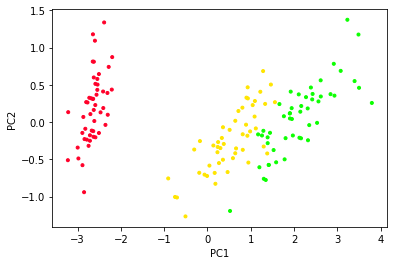

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Get prior

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


# Get VB params 

In [6]:
k_approx = 30

In [7]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1459.0115663552124

## Initialize 

In [10]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
6580.095037059639


In [11]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

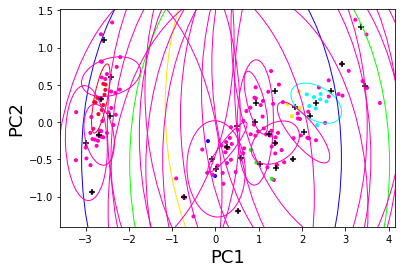

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Run CAVI

In [13]:
vb_opt_dict, e_z_cavi = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False)

done. num iterations = 266
stick_time: 1.504sec
cluster_time: 0.149sec
e_z_time: 0.385sec
**TOTAL time: 4.609sec**


In [14]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Define objective

In [15]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = [vb_params_paragami, prior_params_paragami],
                                free = True,
                                argnums = [1, 2])

objective_fun = lambda x, y : get_vb_params_loss(features, x, y, gh_loc, gh_weights)


In [16]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum=0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum=0)
obj_fun_hvp = autograd.hessian_vector_product(
            objective_fun, argnum=0)

# Derivative times

In [17]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.00929sec


In [18]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.0547sec


In [19]:
# if its impossible, don't run the hessian
run_hessian = True

In [20]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

hessian time: 19.9sec


In [21]:
t0 = time.time()

x = np.zeros(len(vb_opt))# vb_opt
x[0] = 1
hvp = obj_fun_hvp(vb_opt, prior_params_free, x)
print('hvp time: {:0.3}sec'.format(time.time() - t0))

hvp time: 0.191sec


In [22]:
# cross hessian 
hyper_obj_fun_grad = \
            autograd.grad(objective_fun, argnum=0)
hyper_obj_cross_hess = autograd.jacobian(hyper_obj_fun_grad, argnum=1)

In [23]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian time: {:0.3}sec'.format(time.time() - t0))

cross-hessian time: 4.27sec


# Solver times

In [24]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.0016sec


In [25]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
dinput_dhyper2 = -cg_solver(cross_hess[:, 0])
    
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 14.1sec


In [26]:
mfvb_preconditioner = preconditioner_lib.get_gmm_preconditioner(vb_opt, vb_params_paragami)

In [27]:
cg_solver_mfvb_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':mfvb_preconditioner})
    
t0 = time.time()
dinput_dhyper3 = -cg_solver_mfvb_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))

preconditioned solver time: 6.28sec


# Lets look at the CG solver in more detail 

### Check out eigenvalues

In [28]:
hess_ev = np.linalg.eigvals(hess)

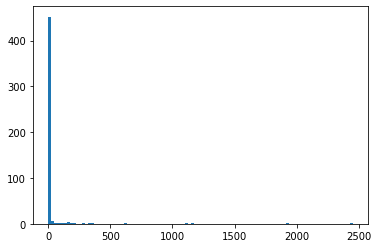

In [29]:
plt.hist(hess_ev - hess_ev.min(), bins = 100);

In [30]:
precond_sqrt = osp.linalg.sqrtm(mfvb_preconditioner.toarray())
np.abs(precond_sqrt - precond_sqrt.transpose()).max()

3.567538391042636e-14

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/lib/histograms.py:854: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/matplotlib/transforms.py:1959: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


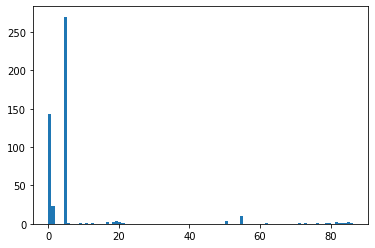

In [31]:
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
precon_hess_ev = np.linalg.eigvals(precond_hess)
plt.hist(precon_hess_ev - precon_hess_ev.min(), bins = 100);

In [32]:
dim = len(vb_opt)
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
linop = osp.sparse.linalg.LinearOperator((dim, dim), mat_times_vec)

b = cross_hess[:, 0]

### Check out optimization path

In [33]:
class CGCallback(): 
    def __init__(self, mat_times_vec, b): 
        self.mat_times_vec = mat_times_vec
        self.b = b
        
        self.residuals = []
        
    def record_residuals(self, x): 
#         e_z = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
#                                        vb_params_paragami.fold(x, free = True), 
#                                        gh_loc, gh_weights)
        
#         e_num_clust = cluster_lib.get_e_num_clusters_from_ez(e_z)
        
#         self.residuals.append(e_num_clust)
        
#         self.residuals.append(np.linalg.norm(b - self.mat_times_vec(x)))

        self.residuals.append(np.linalg.norm(-x - dinput_dhyper[:, 0]))
        
    def return_path(self): 
        return np.array(self.residuals)

In [34]:
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
b = cross_hess[:, 0]
cg_callback = CGCallback(mat_times_vec, b)

x0 = mfvb_preconditioner.dot(b)

In [35]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path1 = cg_callback.return_path()

solver time: 13.4sec


In [36]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':mfvb_preconditioner, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path2 = cg_callback.return_path()

solver time: 6.94sec


Text(0, 0.5, 'log10 residual')

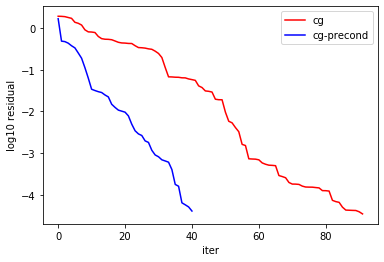

In [37]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond')
plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Try nystrom

In [38]:
def taylor_expand_matrix_inverse(mat_vec, v, max_eval, max_iter):
    
    t_power = deepcopy(v)
    x_inv_v = deepcopy(v)
    
    for i in range(max_iter): 
        t_power = t_power - mat_vec(t_power) / (max_eval + 1)
        x_inv_v += t_power
    
    return x_inv_v / (max_eval + 1)

In [39]:
# a quick test 
dim = 3
_a = np.random.randn(dim, dim)
a = np.dot(_a, _a.transpose())

mat_vec = lambda x: np.dot(a, x)

max_eval = np.linalg.eigvals(a).max()

v = np.random.randn(dim)

foo = taylor_expand_matrix_inverse(mat_vec, v, max_eval, max_iter = 1000)

true = np.linalg.solve(a, v)

print(foo / true)

[0.99998116 0.99998158 0.99998168]


In [40]:
def get_nystrom_woodbury_approx(A, indx): 
    C = A[:, indx]
    W_inv = np.linalg.inv(A[indx][:, indx])
    
    inv_term = np.linalg.inv(np.eye(C.shape[1]) - np.dot(W_inv, np.dot(C.transpose(), C)))
    
    woodb_inv = np.eye(C.shape[0]) + np.dot(np.dot(C, inv_term), np.dot(W_inv, C.transpose()))
    
    return woodb_inv, C, W_inv

In [41]:
# another quick test 
a = np.random.randn(3, 3)
A = np.eye(3) + np.dot(a, a.transpose())

woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A, indx = np.array([0, 1]))

A_tilde = np.dot(np.dot(C, W_inv), C.transpose())

np.abs(np.linalg.inv(np.eye(3) - A_tilde) - woodb_inv).max()

4.440892098500626e-16

## Get large clusters

In [42]:
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                       vb_params_paragami.fold(vb_opt, free = True), 
                                       gh_loc, gh_weights)

In [43]:
k_large = 5
which_k = np.argsort(-e_z_opt.mean(0))[0:k_large]

In [44]:
which_k

array([2, 4, 0, 1, 3])

In [45]:
import bnpgmm_runjingdev.hessian_lib as hessian_lib

In [46]:
sub_vb_params_dict, sub_vb_params_paragami, indx = \
    hessian_lib.get_subvb_params(which_k, vb_opt, vb_params_paragami)

In [47]:
len(indx)

78

In [48]:
est_lambda_max = np.max(np.linalg.eigvals(hess)) 
# est_lambda_max = np.abs(hess).sum(0).max() * 100.

A = np.eye(hess.shape[0]) - hess / est_lambda_max

In [49]:
print('est lambda_max: ', est_lambda_max)
print('true lambda_max: ', np.max(np.linalg.eigvals(hess)))

est lambda_max:  2451.1259105527097
true lambda_max:  2451.1259105527097


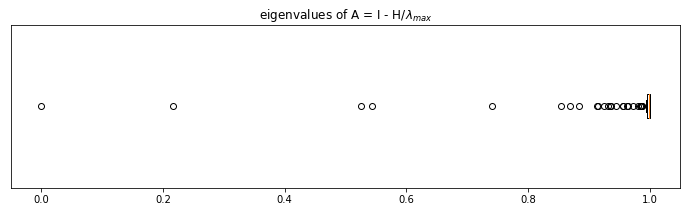

In [50]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(np.linalg.eigvals(A), vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of A = I - H/$\lambda_{max}$'); 

In [51]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A, indx)
nystrom_precond = woodb_inv/est_lambda_max

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


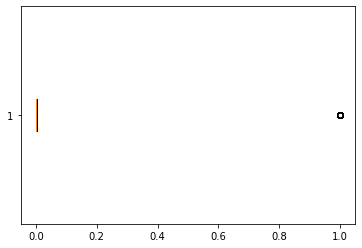

In [52]:
woodb_inv_sqrt = osp.linalg.sqrtm(woodb_inv)
m = np.dot(woodb_inv_sqrt, np.dot(np.eye(len(A)) - A, woodb_inv_sqrt))
plt.boxplot(np.linalg.eigvals(m), vert=False);
# plt.hist(np.linalg.eigvals(m))

In [53]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.max())
print(evals.max() / evals.min())

(1.0000006665435692-2.468404886042761e-17j)
(7613.930036530488-2.3582579136574237e-13j)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


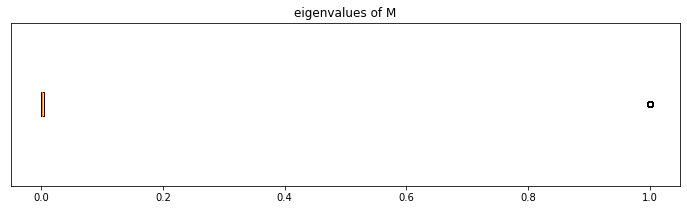

In [54]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [55]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path3 = cg_callback.return_path()

solver time: 5.2sec


Text(0, 0.5, 'log10 residual')

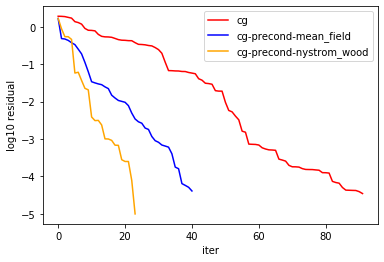

In [56]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Crazy idea ... use only one block

In [57]:
bin_mat1 = np.zeros(hess.shape)
bin_mat1[indx] = 1.0

bin_mat2 = np.zeros(hess.shape)
bin_mat2[:, indx] = 1.0

bin_mat = bin_mat1 * bin_mat2

In [58]:
assert np.all(bin_mat[indx][:, indx] == 1)
assert np.all(bin_mat * (1 - bin_mat) == 0)

In [59]:
# set some blocks to zero
A2 = np.eye(hess.shape[0]) - hess * bin_mat / est_lambda_max

In [60]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A2, indx)
nystrom_precond2 = woodb_inv/est_lambda_max

In [61]:
np.abs(nystrom_precond2 - nystrom_precond).max()

0.07426952886789517

In [62]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond2)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.min())
print(evals.max())

(0.000131159388453024+0j)
(1.0000195574691764+0j)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


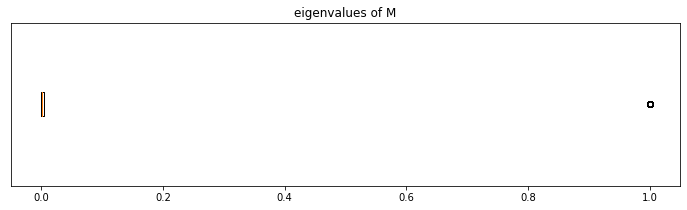

In [63]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [64]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond2, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path4 = cg_callback.return_path()

solver time: 4.01sec


Text(0, 0.5, 'log10 residual')

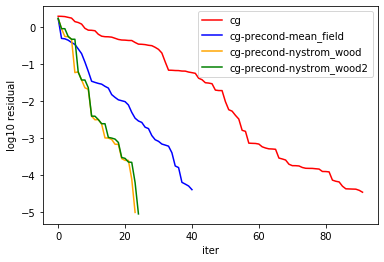

In [65]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')
plt.plot(np.log10(path4), color = 'green', label = 'cg-precond-nystrom_wood2')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Try to estimate that one block

In [66]:
which_k

array([2, 4, 0, 1, 3])

In [67]:
# check dictionaries match ... 
print(np.abs(vb_params_dict['cluster_params']['centroids'][:, np.sort(which_k)] - \
        sub_vb_params_dict['cluster_params']['centroids']).max())

print(np.abs(vb_params_dict['cluster_params']['cluster_info'][np.sort(which_k)] - \
        sub_vb_params_dict['cluster_params']['cluster_info']).max())

print(np.abs(vb_params_dict['stick_params']['stick_propn_mean'][np.sort(which_k[:-1])] - \
        sub_vb_params_dict['stick_params']['stick_propn_mean']).max())

print(np.abs(vb_params_dict['stick_params']['stick_propn_info'][np.sort(which_k[:-1])] - \
        sub_vb_params_dict['stick_params']['stick_propn_info']).max())

0.0
7.105427357601002e-15
0.0
0.0


In [179]:
par

In [180]:
def _get_kl_subparams(y, which_k, sub_vb_params_dict, vb_params_dict, prior_params_dict, gh_loc, gh_weights): 
        
    # get indices
    k_approx = vb_params_dict['cluster_params']['cluster_info'].shape[0]
    which_not_k = np.delete(np.arange(k_approx), which_k)
    h_all = np.hstack((np.sort(which_k), which_not_k))
    sort_indx = np.argsort(h_all)

    # construct vb params 
    centroids = np.hstack((sub_vb_params_dict['cluster_params']['centroids'], 
                       vb_params_dict['cluster_params']['centroids'][:, which_not_k]))[:, sort_indx]

    cluster_info = np.vstack((sub_vb_params_dict['cluster_params']['cluster_info'], 
                       vb_params_dict['cluster_params']['cluster_info'][which_not_k]))[sort_indx]

    # get indices for sticks
    # last stick is deterministic; one less stick param than k_approx
    if(np.any(which_k == (k_approx - 1))):
        _which_k = which_k[which_k != (k_approx - 1)]
    else:
        _which_k = which_k[:-1]
    
    _which_not_k = np.delete(np.arange(k_approx - 1), _which_k)
    _h_all = np.hstack((np.sort(_which_k), _which_not_k))
    _sort_indx = np.argsort(_h_all)


    # construct vb params for sticks
    stick_propn_mean = np.hstack((sub_vb_params_dict['stick_params']['stick_propn_mean'], 
                                  vb_params_dict['stick_params']['stick_propn_mean'][_which_not_k]))[_sort_indx]

    stick_propn_info = np.hstack((sub_vb_params_dict['stick_params']['stick_propn_info'], 
                                  vb_params_dict['stick_params']['stick_propn_info'][_which_not_k]))[_sort_indx]

    vb_params_dict_copy = deepcopy(vb_params_dict)
    vb_params_dict_copy['cluster_params']['centroids'] = centroids
    vb_params_dict_copy['cluster_params']['cluster_info'] = cluster_info
    vb_params_dict_copy['stick_params']['stick_propn_mean'] = stick_propn_mean
    vb_params_dict_copy['stick_params']['stick_propn_info'] = stick_propn_info

    return gmm_lib.get_kl(y, vb_params_dict_copy, prior_params_dict, gh_loc, gh_weights), \
                    vb_params_dict_copy

In [208]:
def _get_kl_subparams2(y, indx, sub_vb_params, 
                       vb_opt, vb_params_paragami, prior_params_dict, gh_loc, gh_weights): 
    
#     which_not_indx = np.delete(np.arange(len(vb_opt)), indx)
#     indx_all = np.hstack((indx, which_not_indx))
#     sort_indx = np.argsort(indx_all)
    
#     vb_opt_copy = np.hstack((sub_vb_params, vb_opt[which_not_indx]))[sort_indx]
    
    return gmm_lib.get_kl(y, vb_params_paragami.fold(replace(sub_vb_params, vb_opt, indx), free = True), \
                       prior_params_dict, gh_loc, gh_weights), 0.0

In [209]:
sub_vb_params = sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True)
kl2, foo2 = _get_kl_subparams2(features, indx, sub_vb_params, vb_opt, 
                              vb_params_paragami, prior_params_dict, gh_loc, gh_weights)

In [210]:
kl2

-381.27894308780714

In [211]:
f = lambda x : _get_kl_subparams2(features, indx, x, vb_opt, 
                              vb_params_paragami, prior_params_dict, gh_loc, gh_weights)[0]
get_sub_hess = autograd.hessian(f)

In [212]:
t0 = time.time()
sub_hess = get_sub_hess(sub_vb_params)
print(time.time() - t0)

2.279240846633911


In [195]:
kl2

-381.27894308780714

In [196]:
np.abs(foo2 - vb_opt).max()

4.440892098500626e-16

In [197]:
kl, foo = _get_kl_subparams(features, which_k, 
                            sub_vb_params_dict, vb_params_dict, prior_params_dict, gh_loc, gh_weights) 

In [198]:
vb_params_dict['cluster_params']['centroids'] - foo['cluster_params']['centroids']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [199]:
np.abs(vb_params_dict['cluster_params']['cluster_info'] - foo['cluster_params']['cluster_info']).max()

7.105427357601002e-15

In [200]:
vb_params_dict['stick_params']['stick_propn_mean'] - foo['stick_params']['stick_propn_mean']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [201]:
vb_params_dict['stick_params']['stick_propn_info'] - foo['stick_params']['stick_propn_info']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [202]:
kl - gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

4.547473508864641e-13

In [203]:
get_sub_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=_get_kl_subparams, 
                                patterns = sub_vb_params_paragami,
                                free = True,
                                argnums = 2)

objective_fun2 = lambda x : get_sub_vb_params_loss(features, which_k, x, vb_params_dict, prior_params_dict,
                                                   gh_loc, gh_weights)[0]


In [204]:
objective_fun2(sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True)) - \
    objective_fun(vb_opt, prior_params_free)

3.410605131648481e-13

In [205]:
get_sub_hess = autograd.hessian(objective_fun2)
get_sub_hess2 = autograd.hessian(_get_kl_subparams2, argnum=2)

In [206]:
t0 = time.time()
sub_hess = get_sub_hess(sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True))
print('sub-hessian time: ', time.time() - t0)

sub-hessian time:  1.615342140197754


In [90]:
est_hess = np.zeros(hess.shape)
error_mat = np.zeros(sub_hess.shape)
for i in range(len(indx)): 
    for j in range(len(indx)): 
        error_mat[i,j] = sub_hess[i, j] - hess[indx[i], indx[j]]
        est_hess[indx[i], indx[j]] = sub_hess[i, j]

In [92]:
np.abs(error_mat).max()

5.684341886080801e-13

In [93]:
# set some blocks to zero
A3 = np.eye(hess.shape[0]) - est_hess / est_lambda_max

In [95]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A3, indx)
nystrom_precond3 = woodb_inv/est_lambda_max

In [96]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond3)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.min())
print(evals.max())

(0.000131159388453204+0j)
(1.000019557495082+0j)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


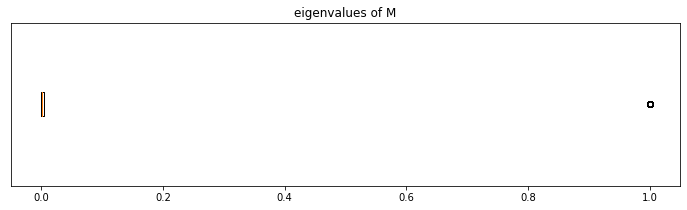

In [97]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [98]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond3, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path5 = cg_callback.return_path()

solver time: 4.11sec


Text(0, 0.5, 'log10 residual')

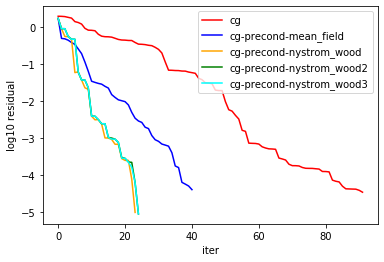

In [99]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')
plt.plot(np.log10(path4), color = 'green', label = 'cg-precond-nystrom_wood2')
plt.plot(np.log10(path5), color = 'cyan', label = 'cg-precond-nystrom_wood3')


plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Can we try to estimate that upper block?

In [242]:
import bnpgmm_runjingdev.hessian_lib as hessian_lib

In [243]:
use_bnp_prior = True

In [ ]:
# just double checking. 
# set dictionary and e_z at optimal value 
vb_params_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                       vb_params_paragami.fold(vb_opt, free = True), 
                                       gh_loc, gh_weights, 
                                        use_bnp_prior=use_bnp_prior)

## Get subparameters

In [ ]:
def get_subvb_params(which_k, vb_opt, vb_params_paragami): 
    bool_dict = vb_params_paragami.empty_bool(False)
    bool_dict['cluster_params']['centroids'][:, which_k] = True
    bool_dict['cluster_params']['cluster_info'][which_k] = True
    
    # last stick is deterministic; one less stick param than k_approx
    _which_k = which_k[:-1]
    bool_dict['stick_params']['stick_propn_mean'][_which_k] = True
    bool_dict['stick_params']['stick_propn_info'][_which_k] = True
    
    # free indices corresponding to sub vb parameters
    indx = vb_params_paragami.flat_indices(bool_dict, free = True)
    
    # get paragami and dictionary for sub vb parameters
    _, sub_vb_params_paragami = \
        gmm_lib.get_vb_params_paragami_object(features.shape[1], len(which_k))
    sub_vb_params_dict = sub_vb_params_paragami.fold(vb_opt[indx], free = True)
    
    return sub_vb_params_dict, sub_vb_params_dict, indx

In [ ]:
sub_vb_params_dict, sub_vb_params_dict, indx2 = \
    get_subvb_params(which_k, vb_opt, vb_params_paragami)

In [ ]:
bool_dict = vb_params_paragami.empty_bool(False)
bool_dict['cluster_params']['centroids'][:, which_k] = True
bool_dict['cluster_params']['cluster_info'][which_k] = True

# _which_k = which_k[:-1]
_which_k = np.sort(which_k)[:-1]
_which_k = _which_k[_which_k != (k_approx - 1)]
bool_dict['stick_params']['stick_propn_mean'][_which_k] = True
bool_dict['stick_params']['stick_propn_info'][_which_k] = True

In [ ]:
indx2 = vb_params_paragami.flat_indices(bool_dict, free = True)

In [ ]:
sub_vb_params_dict, sub_vb_params_paragami = gmm_lib.get_vb_params_paragami_object(features.shape[1], k_large)

In [ ]:
which_k_sorted = np.sort(which_k)
_which_k_sorted = np.sort(_which_k)

In [ ]:
which_k_sorted

In [ ]:
_which_k_sorted

In [ ]:
sub_vb_params_dict['cluster_params']['centroids'] = \
    vb_params_dict['cluster_params']['centroids'][:, which_k_sorted]
sub_vb_params_dict['cluster_params']['cluster_info'] = \
    vb_params_dict['cluster_params']['cluster_info'][which_k_sorted]

sub_vb_params_dict['stick_params']['stick_propn_mean'] = \
    vb_params_dict['stick_params']['stick_propn_mean'][_which_k_sorted]
sub_vb_params_dict['stick_params']['stick_propn_info'] = \
    vb_params_dict['stick_params']['stick_propn_info'][_which_k_sorted]

In [ ]:
sub_vb_params_free = sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True)

In [ ]:
np.abs(sub_vb_params_free - vb_opt[indx2]).max()

In [ ]:
sub_vb_params_dict

In [ ]:
def get_subkl(y, sub_vb_params_dict, vb_params_dict, prior_params_dict, gh_loc, gh_weights): 
    n_sub_clusters = sub_vb_params_dict['cluster_params']['centroids'].shape[1]
    
    # TODO: this assumes the k largest clusters are the first n_sub_cluster indices
    centroids = np.hstack((sub_vb_params_dict['cluster_params']['centroids'], 
                       vb_params_dict['cluster_params']['centroids'][:, n_sub_clusters:]))
    
    cluster_info = np.vstack((sub_vb_params_dict['cluster_params']['cluster_info'], 
                       vb_params_dict['cluster_params']['cluster_info'][n_sub_clusters:]))
    
    
    stick_propn_mean = np.hstack((sub_vb_params_dict['stick_params']['stick_propn_mean'], 
                                  vb_params_dict['stick_params']['stick_propn_mean'][(n_sub_clusters-1):]))
    
    stick_propn_info = np.hstack((sub_vb_params_dict['stick_params']['stick_propn_info'], 
                                  vb_params_dict['stick_params']['stick_propn_info'][(n_sub_clusters-1):]))
    
    vb_params_dict_copy = deepcopy(vb_params_dict)
    vb_params_dict_copy['cluster_params']['centroids'] = centroids
    vb_params_dict_copy['cluster_params']['cluster_info'] = cluster_info
    vb_params_dict_copy['stick_params']['stick_propn_mean'] = stick_propn_mean
    vb_params_dict_copy['stick_params']['stick_propn_info'] = stick_propn_info
    
    return gmm_lib.get_kl(y, vb_params_dict_copy, prior_params_dict, gh_loc, gh_weights), vb_params_dict_copy

In [ ]:
kl, foo = get_subkl(features, sub_vb_params_dict, vb_params_dict, prior_params_dict, gh_loc, gh_weights) 

In [ ]:
np.abs(vb_params_paragami.flatten(foo, free = False) -
       vb_params_paragami.flatten(vb_params_dict, free = False)).max()

In [ ]:
np.abs(vb_params_paragami.flatten(foo, free = True) -
       vb_params_paragami.flatten(vb_params_dict, free = True)).max()

In [ ]:
kl - gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

In [ ]:
get_sub_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=get_subkl, 
                                patterns = sub_vb_params_paragami,
                                free = True,
                                argnums = 1)

objective_fun2 = lambda x : get_sub_vb_params_loss(features, x, vb_params_dict, prior_params_dict,
                                                   gh_loc, gh_weights)[0]


In [ ]:
objective_fun2(sub_vb_params_free) - objective_fun(vb_opt, prior_params_free)

In [ ]:
get_sub_hess = autograd.hessian(objective_fun2)

In [ ]:
t0 = time.time()
sub_hess = get_sub_hess(sub_vb_params_free)
print('sub-hessian time: ', time.time() - t0)

In [ ]:
sub_hess.shape

In [ ]:
est_hess = np.zeros(hess.shape)
error_mat = np.zeros(sub_hess.shape)
for i in range(len(indx2)): 
    for j in range(len(indx2)): 
        error_mat[i,j] = sub_hess[i, j] - hess[indx2[i], indx2[j]]
        est_hess[indx2[i], indx2[j]] = sub_hess[i, j]

In [ ]:
error_mat.max()

In [ ]:
# set some blocks to zero
A3 = np.eye(hess.shape[0]) - est_hess / est_lambda_max

In [ ]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A3, indx2)
nystrom_precond3 = woodb_inv/est_lambda_max

In [ ]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond3)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.min())
print(evals.max())

In [ ]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [ ]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond3, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path5 = cg_callback.return_path()

In [ ]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')
plt.plot(np.log10(path4), color = 'green', label = 'cg-precond-nystrom_wood2')
plt.plot(np.log10(path5), color = 'cyan', label = 'cg-precond-nystrom_wood3')


plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')